<a href="https://colab.research.google.com/github/LeoDinga/DL_Project/blob/main/DL_project_Leo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/THETIS-dataset/dataset.git
!mv dataset data

Cloning into 'dataset'...
remote: Enumerating objects: 8471, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 8471 (delta 0), reused 5 (delta 0), pack-reused 8465 (from 1)
Receiving objects: 100% (8471/8471), 12.70 GiB | 28.94 MiB/s, done.
Resolving deltas: 100% (54/54), done.
Updating files: 100% (8379/8379), done.


In [ ]:
#!pip install torch torchvision opencv-python matplotlib scikit-learn Pillow

In [1]:
import os
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import torchvision.models as models
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score

In [4]:
# See if it can find the videos
for root, dirs, files in os.walk("data"):
    if any(f.endswith(('.mp4', '.avi')) for f in files):
        print(f"Found videos in: {root}")

Found videos in: data/VIDEO_Skelet2D/kick_service
Found videos in: data/VIDEO_Skelet2D/backhand_volley
Found videos in: data/VIDEO_Skelet2D/slice_service
Found videos in: data/VIDEO_Skelet2D/flat_service
Found videos in: data/VIDEO_Skelet2D/backhand_slice
Found videos in: data/VIDEO_Skelet2D/forehand_flat
Found videos in: data/VIDEO_Skelet2D/forehand_volley
Found videos in: data/VIDEO_Skelet2D/smash
Found videos in: data/VIDEO_Skelet2D/backhand2hands
Found videos in: data/VIDEO_Skelet2D/forehand_slice
Found videos in: data/VIDEO_Skelet2D/forehand_openstands
Found videos in: data/VIDEO_Skelet2D/backhand
Found videos in: data/VIDEO_Mask/kick_service
Found videos in: data/VIDEO_Mask/backhand_volley
Found videos in: data/VIDEO_Mask/slice_service
Found videos in: data/VIDEO_Mask/flat_service
Found videos in: data/VIDEO_Mask/backhand_slice
Found videos in: data/VIDEO_Mask/forehand_flat
Found videos in: data/VIDEO_Mask/forehand_volley
Found videos in: data/VIDEO_Mask/smash
Found videos in: da

In [5]:
# Similar to the previous one but it also shows the videos in each folder
import os

data_path = 'data'

# Print out the directory structure
for root, dirs, files in os.walk(data_path):
    print(f"Root: {root}")
    print(f"Dirs: {dirs}")
    print(f"Files: {files}")
    print("-" * 40)

Root: data
Dirs: ['VIDEO_Skelet2D', 'VIDEO_Mask', 'papers', '.git', 'VIDEO_RGB', 'VIDEO_Skelet3D', 'VIDEO_Depth']
Files: ['README.md']
----------------------------------------
Root: data/VIDEO_Skelet2D
Dirs: ['kick_service', 'backhand_volley', 'slice_service', 'flat_service', 'backhand_slice', 'forehand_flat', 'forehand_volley', 'smash', 'backhand2hands', 'forehand_slice', 'forehand_openstands', 'backhand']
Files: []
----------------------------------------
Root: data/VIDEO_Skelet2D/kick_service
Dirs: []
Files: ['p30_serkick_skelet2D_s2.avi', 'p11_serkick_skelet2D_s1.avi', 'p7_serkick_skelet2D_s1.avi', 'p47_serkick_skelet2D_s2.avi', 'p5_serkick_skelet2D_s2.avi', 'p46_serkick_skelet2D_s2.avi', 'p53_serkick_skelet2D_s1.avi', 'p17_serkick_skelet2D_s1.avi', 'p54_serkick_skelet2D_s2.avi', 'p15_serkick_skelet2D_s2.avi', 'p4_serkick_skelet2D_s2.avi', 'p52_serkick_skelet2D_s2.avi', 'p1_serkick_skelet2D_s2.avi', 'p12_serkick_skelet2D_s2.avi', 'p32_serkick_skelet2D_s2.avi', 'p17_serkick_skelet2D

In [7]:

def extract_frames(video_path, num_frames=64):
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # If the video is too short, return an empty list
    if total < num_frames or total == 0:
        cap.release()
        return []

    step = max(total // num_frames, 1)
    frames = []

    for i in range(num_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (224, 224))  # Resize to match ResNet input size
        frames.append(frame)

    cap.release()
    return frames

In [9]:
class TennisDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_frames=16):
        self.samples = []
        self.transform = transform
        self.num_frames = num_frames
        self.label_map = {}  # This will map class names to indices (0-11)

        # Step 1: Find all 12 class folders
        class_folders = set()
        for root, dirs, files in os.walk(root_dir):
            # Look for folders containing videos, but skip intermediate dirs e.g VIDEO_Mask
            if any(f.endswith(('.mp4', '.avi')) for f in files):
                class_name = os.path.basename(root)
                class_folders.add(class_name)

        # Assign labels 0-11 to classes
        self.label_map = {cls: idx for idx, cls in enumerate(sorted(class_folders))}
        self.idx_to_class = {idx: cls for cls, idx in self.label_map.items()}

        # Step 2: Load samples
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                if file.endswith(('.mp4', '.avi')):
                    class_name = os.path.basename(root)
                    self.samples.append((
                        os.path.join(root, file),
                        self.label_map[class_name]
                    ))

        print(f"Loaded {len(self.samples)} videos. Classes: {self.label_map}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        frames = extract_frames(path, self.num_frames)
        if not frames:
            return self.__getitem__((idx + 1) % len(self))  # this will skip corrupted videos
        frames = torch.stack([self.transform(Image.fromarray(f)) for f in frames])
        return frames.float(), label  # Ensure float32

In [10]:
class CNN_LSTM(nn.Module):
    def __init__(self, num_classes=12, hidden_size=256):
        super(CNN_LSTM, self).__init__()
        base = models.resnet18(pretrained=True)
        self.cnn = nn.Sequential(*list(base.children())[:-1])
        self.lstm = nn.LSTM(input_size=512, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        B, T, C, H, W = x.size()
        x = x.view(B*T, C, H, W)
        with torch.no_grad():
            feats = self.cnn(x).view(B, T, -1)
        out, _ = self.lstm(feats)
        return self.fc(out[:, -1, :])


In [11]:
def train(model, train_loader, val_loader, device, num_epochs=10):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        all_preds, all_labels = [], []
        for clips, labels in train_loader:
            clips, labels = clips.to(device), labels.to(device)
            outputs = model(clips)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        train_acc = accuracy_score(all_labels, all_preds)

        # Validation
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for clips, labels in val_loader:
                clips, labels = clips.to(device), labels.to(device)
                outputs = model(clips)
                val_preds.extend(outputs.argmax(dim=1).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        val_acc = accuracy_score(val_labels, val_preds)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])
dataset = TennisDataset(root_dir="data/VIDEO_Mask", transform=transform) # This will use only the videos from dir VIDEO_Mask
print(f"Number of classes: {len(dataset.label_map)}")

# full_dataset = TennisDataset("data", transform=transform, num_frames=16)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=2)

model = CNN_LSTM(num_classes=12)
train(model, train_loader, val_loader, device, num_epochs=10)

Loaded 1980 videos. Classes: {'backhand': 0, 'backhand2hands': 1, 'backhand_slice': 2, 'backhand_volley': 3, 'flat_service': 4, 'forehand_flat': 5, 'forehand_openstands': 6, 'forehand_slice': 7, 'forehand_volley': 8, 'kick_service': 9, 'slice_service': 10, 'smash': 11}
Number of classes: 12


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 147MB/s]


Epoch 1/10, Loss: 2.4642, Train Acc: 0.1155, Val Acc: 0.2172
Epoch 2/10, Loss: 2.2294, Train Acc: 0.2374, Val Acc: 0.3283
Epoch 3/10, Loss: 1.8333, Train Acc: 0.3775, Val Acc: 0.3737
Epoch 4/10, Loss: 1.5736, Train Acc: 0.4362, Val Acc: 0.3687
Epoch 5/10, Loss: 1.4269, Train Acc: 0.4716, Val Acc: 0.4470


In [1]:
def show_batch_multiframe(dataloader, num_frames=4):
    batch, _ = next(iter(dataloader))
    batch = batch[0]  # Take first sample
    video_path = "data/VIDEO_Mask/forehand_openstands" # First sample's path
    video_name = os.path.basename(video_path)

    fig, axes = plt.subplots(1, num_frames, figsize=(15, 3))
    for i in range(num_frames):
        frame = batch[i].permute(1, 2, 0).cpu().numpy()
        axes[i].imshow(np.clip(frame, 0, 1))
        axes[i].set_title(f"{video_name}\nFrame {i+1}")
        axes[i].axis('off')


    plt.show()

show_batch_multiframe(train_loader, num_frames=16)

NameError: name 'train_loader' is not defined

NameError: name 'clip' is not defined

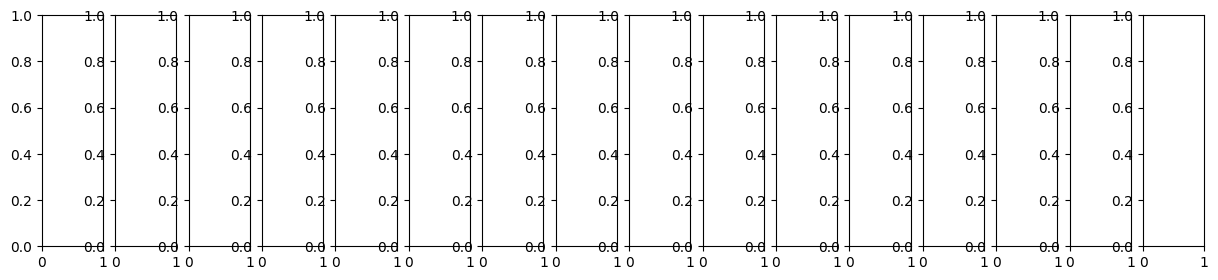

In [ ]:
def show_batch_multiframe(dataloader, num_frames=4):
    # Get one batch
    batch, _ = next(iter(dataloader))
    batch = batch[0]  # Shape: (num_frames, C, H, W)

    # Get video filename
    video_path = f"data/VIDEO_Mask/forehand_backhand"[0][0]  # First sample's path
    video_name = os.path.basename(video_path)

    # Create plot
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 3))

    for i in range(num_frames):
        frame = clip[i].permute(1, 2, 0).cpu().numpy()
        frame = np.clip(frame, 0, 1)  # Fix range

        axes[i].imshow(frame)
        axes[i].set_title(f"{video_name}\nFrame {i+1}" if i==0 else f"Frame {i+1}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

show_batch_multiframe(train_loader, num_frames=16)

In [ ]:
#verify if classes are okay
print("Label range:", min(dataset.label_map.values()), "-", max(dataset.label_map.values()))
print("Model expects:", model.fc.out_features, "classes")

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.save(model.state_dict(), "cnn_lstm_tennis.pth")
print("Model saved to cnn_lstm_tennis.pth")

Model saved to cnn_lstm_tennis.pth


In [ ]:
def predict_video(model, video_path, device, transform, label_map):
    model.eval()
    frames = extract_frames(video_path, num_frames=16)
    frames = [transform(Image.fromarray(f)) for f in frames]
    clip = torch.stack(frames).unsqueeze(0).to(device)  # (1, T, C, H, W)
    with torch.no_grad():
        output = model(clip)
        pred_idx = output.argmax(dim=1).item()
    return label_map[pred_idx]

In [ ]:
pred = predict_video(model, "data/VIDEO_Mask/forehand_openstands", device, transform, full_dataset.idx_to_class)
print("Predicted:", pred)

RuntimeError: stack expects a non-empty TensorList